# read, import

In [2]:
import pandas as pd
import numpy as np
import os
import xlrd

import seaborn as sns
import csv
import sklearn
from sklearn import linear_model
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Perceptron
from sklearn.manifold import TSNE
from sklearn import preprocessing 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler  
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression,LogisticRegression
from matplotlib.axes import Axes
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import itertools
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_blobs
from pandas import read_csv
from numpy import nan
from numpy import mean
from numpy import std
from scipy import stats
import matplotlib.pyplot as plt
#from scipy.cluster.hierarchy import dendrogram, fcluster
sns.set(style="whitegrid")
#np.random.seed(203)

# Data import

In [19]:
model_path = "vae_nets"
T1_model_names = ["control_T1_5_250"] + ["control_T1_5_250_b{}".format(i) for i in range(2, 11, 2)]
T1_model_names += ["control_T1_5_250_b{}".format(i) for i in [20, 30, 40]]
latent_paths = [os.path.join(model_path, model_name, "{}_both_latents.csv".format(model_name)) for model_name in T1_model_names]

In [ ]:
# DTI
#dti = pd.read_csv('data/DTI_cleaned_v3.csv')
dti=pd.read_csv("/content/drive/MyDrive/ENIGMA/Data/ENIGMA/nonCombat_Data/DTI_cleaned_v3.csv")
print(dti.shape)
# T1
#t1 = pd.read_csv('data/T1_cleaned_v2.csv')
t1=pd.read_csv("/content/drive/MyDrive/ENIGMA/Data/ENIGMA/nonCombat_Data/T1_cleaned_v2.csv")
print(t1.shape)
# merged T1 & DTI
#merged = pd.read_excel('data/t1_dti_without_vol_2021.3.19.xlsx')
merged=pd.read_csv("/content/drive/MyDrive/ENIGMA/Data/ENIGMA/nonCombat_Data/t1_dti_without_vol_2021.3.19.csv")
print(merged.shape)
#RS
rs=pd.read_csv("/content/drive/MyDrive/ENIGMA/Data/ENIGMA/nonCombat_Data/RS_corr_264_merged_20210327.csv")
print(rs.shape)

In [ ]:
latent_nums = [5, 10]
hidden_nums = [50, 100, 150, 200, 250]

T1_dfs = {}
for latent_num in latent_nums:
  for hidden_num in hidden_nums:
    curr_fname = "control_T1_{}_{}_both_latents.csv".format(latent_num, hidden_num)
    curr_key = "{}_{}".format(latent_num, hidden_num)
    T1_dfs[curr_key] = pd.read_csv("/content/drive/MyDrive/ENIGMA/Data/ENIGMA/nonCombat_Data/VAE_reduced_Features/T1/{}".format(curr_fname))


In [21]:
T1_dfs = {}
for mname, lpath in zip(T1_model_names, latent_paths):
    T1_dfs[mname] = pd.read_csv(lpath)


In [ ]:
##os.path.exists("/content/drive/MyDrive/ENIGMA/Data/ENIGMA/nonCombat_Data/VAE_reduced_Features/RS/control_RS_10_400_both_latents.csv")
rs=pd.read_csv("/content/drive/MyDrive/ENIGMA/Data/ENIGMA/nonCombat_Data/VAE_reduced_Features/RS/control_RS_10_400_both_latents.csv")

In [22]:
for df in T1_dfs.values():
  df.drop(columns=["Site", "SubjectID"], inplace=True)

In [ ]:
for df in T1_dfs.values():
  df.drop(columns=["Site"], inplace=True)

In [11]:
print(T1_dfs)

{'control_T1_5_250':       Diagnosis      mu_0      mu_1      mu_2      mu_3      mu_4  logvar_0  \
0             0  1.909647  0.679410 -1.044482  1.855205 -0.384414 -0.942153   
1             1  0.187326  0.322715 -0.468075  2.281667 -0.006033 -0.274456   
2             1  2.123714  1.499596 -1.112499  2.151797 -0.396342 -0.981731   
3             1  2.315059  0.365774 -0.830348  2.050200  0.032975 -1.040930   
4             1  2.024572  1.037004 -1.003641  1.826627 -0.595815 -1.167555   
...         ...       ...       ...       ...       ...       ...       ...   
2442          1  1.709637  0.412934 -0.429104  1.277517 -0.551883 -1.001554   
2443          1  0.379496  0.556262 -0.109278  0.792577 -0.453797 -0.766619   
2444          0 -0.800944  2.722705 -1.223243 -1.010020 -0.328811 -0.563220   
2445          0  1.230440 -1.571095  1.733489  2.512369 -0.702696 -1.024002   
2446          1  0.780258  1.426679 -1.036873  0.071830 -0.461977 -1.066225   

      logvar_1  logvar_2  logv

## Data cleaning

In [ ]:
# llist = dti.columns.str.findall('_L')
# boollist = llist.astype(bool)
# cols = dti[dti.columns[boollist]].columns.str.rstrip('_L')
dti.drop(columns=['Unnamed: 0', 'SubjID', 'SiteID',  'Sex', 'Age'], inplace=True) #'Site',
dti = dti[~(dti.CurrPTSDdx.isnull())]

In [ ]:
# t1.drop(columns=['Unnamed: 0', 'Site', 'SubjID', 'Age', 'Sex', 'LifePTSDdx', 'Internal_QC', 'External_QC', 'PTSDdxTool',
#                  'PTSDsevTool', 'CurrPTSDsev', 'LifePTSDsev', 'LThickness', 
#                  'RThickness', 'LSurfArea', 'RSurfArea', 'ICV', 'LThickness.1', 'RThickness.1', 'LSurfArea.1', 'RSurfArea.1', 
#                  'ICV.1', 'LThickness.2', 'RThickness.2', 'LSurfArea.2', 'RSurfArea.2', 'ICV.2'])
t1.drop(columns=['Unnamed: 0',  'SubjID', 'Age', 'Sex', 'Internal_QC', 'External_QC', 'PTSDdxTool',
                 'PTSDsevTool', 'LifePTSDsev'], inplace=True) #'Site',
t1.replace(0, np.nan, inplace=True)

In [ ]:
t1.Diagnosis.isnull().any()
t1 = t1[~(t1.Diagnosis.isnull())]
t1 = t1[~(t1.Diagnosis == 'SubThresh')]
t1.loc[t1.Diagnosis.isin(['TEHC','HC', 'Control']),'Diagnosis'] = 'Control'

In [ ]:
merged.drop(columns=['SubjID','Sex', 'Age', 'SiteID', 'LifePTSDdx', 'CurrPTSDdx_duplicate', 'Internal_QC', 'External_QC', 'PTSDdxTool',
                 'PTSDsevTool', 'CurrPTSDsev', 'LifePTSDsev'], inplace=True) # 'Site',
merged = merged[~(merged.CurrPTSDdx.isnull())]
merged = merged[~(merged.CurrPTSDdx == 'SubThresh')]
merged.loc[merged.CurrPTSDdx.isin(['TEHC','HC','Control']),'CurrPTSDdx'] = 'Control'

In [ ]:
##rs=rs.drop(['SubjectID','Age','Sex'], axis = 1)  #'Site',
rs=rs.drop(['SubjectID','Site'], axis = 1)  #'Site',
rs = rs[~(rs.Diagnosis.isnull())]

In [ ]:
print(rs['Diagnosis'])

Index(['Diagnosis', 'mu_0', 'mu_1', 'mu_2', 'mu_3', 'mu_4', 'mu_5', 'mu_6',
       'mu_7', 'mu_8', 'mu_9', 'logvar_0', 'logvar_1', 'logvar_2', 'logvar_3',
       'logvar_4', 'logvar_5', 'logvar_6', 'logvar_7', 'logvar_8', 'logvar_9'],
      dtype='object')


**Drop features that have more than 30% missing data**  drop features/columns with >30% zeros

In [ ]:
print(dti.shape)
print(t1.shape)
print(merged.shape)
print(rs.shape)

#dti
#print(dti.isnull().sum())
dti=dti.loc[:, pd.notnull(dti).sum()>len(dti)*.9]
print(dti.shape)

#t1
#print(t1.isnull().sum())
t1=t1.loc[:, pd.notnull(t1).sum()>len(t1)*.7]
print(t1.shape)

#merged
# print(merged.isnull().sum())
merged=merged.loc[:, pd.notnull(merged).sum()>len(merged)*.7]
print(merged.shape)

#RS
#print(rs.isnull().sum())
rs=rs.loc[:, pd.notnull(rs).sum()>len(rs)*.7]
print(rs.shape)

(1953, 44)
(2522, 278)
(1037, 287)
(2516, 34981)
(1953, 44)
(2522, 278)
(1037, 287)
(2516, 34981)


# Data exploration

Text(0, 0.5, 'Count')

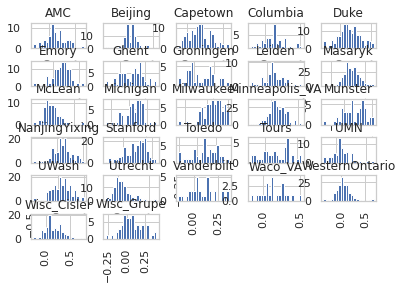

In [ ]:
# df=rs
# #df = df[df['Site'] == 'AMC']
# #plt.hist(dti['ACR_L'], bins = 20)
# df['ROI1-ROI2'].hist(by=df['Site'], bins=20)
# plt.ylabel('Count')
# # plt.xlabel('ACR_L')
# # plt.title('Distribution of ACR_L')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


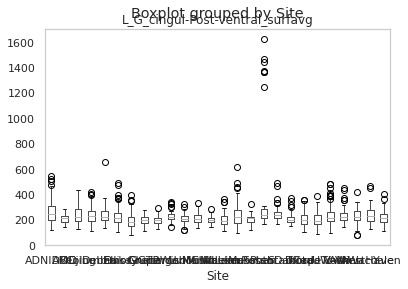

In [ ]:
#t1.boxplot(by ='Site', column =['L_G_cingul-Post-ventral_surfavg'], grid = False) #L_G_cingul-Post-ventral_surfavg
#df.boxplot(by ='Site', column =['ROI122-ROI242'], grid = False)

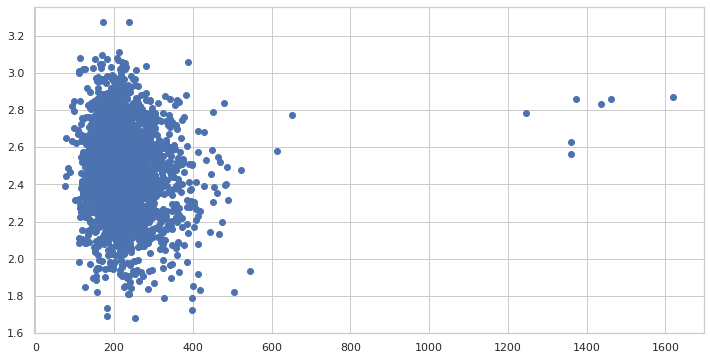

In [ ]:
# fig, ax = plt.subplots(figsize=(12,6))
# ax.scatter(t1['L_G_cingul-Post-ventral_surfavg'], t1['R_S_temporal_inf_thickavg'])
# plt.show()

In [ ]:
dti.drop(columns=['Site'], inplace=True)
t1.drop(columns=['Site'], inplace=True)
merged.drop(columns=['Site'], inplace=True)
rs.drop(columns=['Site'], inplace=True)

In [ ]:
# df=t1
# print(df.shape)
# for col in range(2,df.shape[1]):
#   sk=df.iloc[:,col].skew()
#   if sk>1:
#     print(df.columns[col],"skew:", sk)
#     Q1 = df.iloc[:,col].quantile(0.25)
#     Q3 = df.iloc[:,col].quantile(0.75)
#     IQR = Q3 - Q1
#     #print(IQR)
#     median=(df.iloc[:,col].quantile(0.50)) 
#     #print(median)
#     df.iloc[:,col] = np.where((df.iloc[:,col] < (Q1 - 1.5 * IQR))|(df.iloc[:,col] > (Q3 + 1.5 * IQR)), median, df.iloc[:,col])
#     print(df.iloc[:,col].skew())
# #df.head()
# print(df.skew())

## train test split, scale

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

def impute_and_standardize(x, y):
    trainx, testx, trainy, testy = train_test_split(x, y, shuffle=True, random_state=42, test_size=0.3)
    
    # remove outliers 
    for col in range(0,trainx.shape[1]):
      sk=trainx.iloc[:,col].skew()
      if sk>1:
        #print(trainx.columns[col],"skew:", sk)
        Q1 = trainx.iloc[:,col].quantile(0.25)
        Q3 = trainx.iloc[:,col].quantile(0.75)
        IQR = Q3 - Q1
        #print('IQR:',IQR)
        median=(trainx.iloc[:,col].quantile(0.50)) 
        trainx.iloc[:,col] = np.where((trainx.iloc[:,col] < (Q1 - 1.5 * IQR))|(trainx.iloc[:,col] > (Q3 + 1.5 * IQR)), median, trainx.iloc[:,col])
        testx.iloc[:,col] = np.where((testx.iloc[:,col] < (Q1 - 1.5 * IQR))|(testx.iloc[:,col] > (Q3 + 1.5 * IQR)), median, testx.iloc[:,col])
        #print(' New skew value:', trainx.iloc[:,col].skew())
    
        # impute
    trainx.fillna(trainx.mean(), inplace=True)
    testx.fillna(trainx.mean(), inplace=True)
    print('trainx',trainx.shape)
    print('testx',testx.shape)

    # scale
    cols = trainx.columns.values
    transformer = RobustScaler().fit(trainx)
    trainx = transformer.transform(trainx)
    testx = transformer.transform(testx)
    trainx = pd.DataFrame(trainx)
    testx = pd.DataFrame(testx)
    trainx.columns = cols
    testx.columns = cols
    
    train = {'trainx': trainx, 'trainy': trainy}
    test = {'testx': testx, 'testy': testy}
    
    return train, test

In [ ]:
##dtitrain, dtitest = impute_and_standardize(dti.drop(columns='CurrPTSDdx'), dti['CurrPTSDdx'])
##t1train, t1test = impute_and_standardize(t1.drop(columns='Diagnosis'), t1['Diagnosis'])
##mtrain, mtest = impute_and_standardize(merged.drop(columns='CurrPTSDdx'), merged['CurrPTSDdx'])
rstrain, rstest = impute_and_standardize(rs.drop(columns='Diagnosis'), rs['Diagnosis'])

trainx (1729, 20)
testx (742, 20)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [23]:
T1_ttsplit = {}
for k, v in T1_dfs.items():
  T1_ttsplit[k] = impute_and_standardize(T1_dfs[k].drop(columns='Diagnosis'), T1_dfs[k]['Diagnosis'])

C:\Users\Orren\anaconda3\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\Orren\anaconda3\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\Orren\anaconda3\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\Orren\anac

trainx (1712, 10)
testx (735, 10)
trainx (1712, 10)
testx (735, 10)
trainx (1712, 10)
testx (735, 10)
trainx (1712, 10)
testx (735, 10)
trainx (1712, 10)
testx (735, 10)
trainx (1712, 10)
testx (735, 10)
trainx (1712, 10)
testx (735, 10)
trainx (1712, 10)
testx (735, 10)
trainx (1712, 10)
testx (735, 10)


C:\Users\Orren\anaconda3\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\Orren\anaconda3\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\Orren\anaconda3\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\Orren\anac

In [ ]:
# X_train=t1train.get('trainx')
# y_train=t1train.get('trainy')
# X_test=t1test.get('testx')
# y_test=t1test.get('testy')

## **Explore multiple ML algorithms**

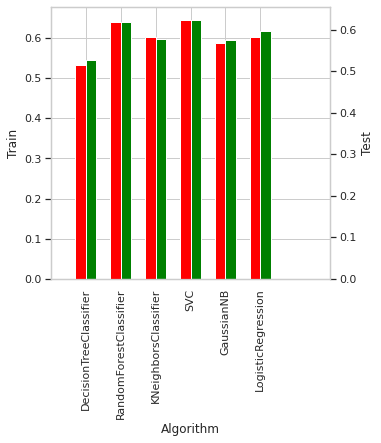

In [ ]:
# #warnings.filterwarnings('ignore')
# # Baseline - comparing model accuracy using all features across classifiers 
# classifiers = [
#     DecisionTreeClassifier(),
#     RandomForestClassifier(),
#     KNeighborsClassifier(),
#     SVC(C=1, gamma='auto', kernel="rbf"),
#     GaussianNB(),
#     LogisticRegression()
#     ]

# # Naive Train Accuracy
# algo = []
# scores = []
# #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)
# #X_train, X_test = scaling(X_train, X_test)

# for clf in classifiers:
#     algo.append(clf.__class__.__name__)
#     scores.append(cross_val_score(clf,X_train,y_train, cv=10).mean())
#     #print(scores)
# Naivescore_df_Train = pd.DataFrame({'Algorithm': algo, 'Score': scores}).set_index('Algorithm')

# # Naive Test Accuracy
# algo = []
# scores = []
# for clf in classifiers:
#     clf = clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
#     algo.append(clf.__class__.__name__)
#     scores.append(accuracy_score(y_pred, y_test))
#     confusion_matrix(y_test, y_pred)

# Naivescore_df_Test  = pd.DataFrame({'Algorithm': algo, 'Score': scores}).set_index('Algorithm')

# # Bar plot between Train and Test Accuracy
# fig = plt.figure(figsize=(5,5)) # Create matplotlib figure
# ax = fig.add_subplot(111) # Create matplotlib axes
# ax2 = ax.twinx() # Create another axes that shares the same x-axis as a
# width = .3

# Naivescore_df_Train.Score.plot(kind='bar',color='green',ax=ax,width=width, position=0)
# Naivescore_df_Test.Score.plot(kind='bar',color='red', ax=ax2,width = width,position=1)

# #ax.grid(None, axis=1)
# ax2.grid(None)

# ax.set_ylabel('Train')
# ax2.set_ylabel('Test')

# ax.set_xlim(-1,7)
# plt.show()#

# Feature reduction methods
# Wrapper methods

Optimal number of features : 17


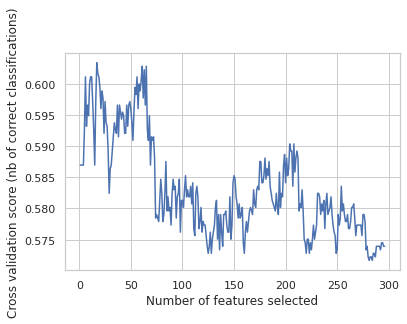

In [ ]:
# # Wrapper methods: Applying RFECV with svm classifier
# svc=SVC(kernel="linear")
# rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(5), # Stratified fold inorder to reduce bias
#               scoring='accuracy')
# rfetrain=rfecv.fit(X_train, y_train)
# print('Optimal number of features :', rfecv.n_features_)

# # Plot showing the Cross Validation score
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (nb of correct classifications)")
# plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
# plt.show()

In [ ]:
# from mlxtend.feature_selection import SequentialFeatureSelector
# SVM_model=SVC(C=1, gamma='auto', kernel="rbf")
# feature_selector = SequentialFeatureSelector(SVM_model,k_features=17,forward=True,verbose=2,scoring='roc_auc',cv=10)
# features = feature_selector.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 296 out of 296 | elapsed:  5.4min finished

[2021-03-31 00:54:34] Features: 1/17 -- score: 0.593682306942936[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 295 out of 295 | elapsed:  5.1min finished

[2021-03-31 00:59:39] Features: 2/17 -- score: 0.6079320327899245[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 294 out of 294 | elapsed:  5.0min finished

[2021-03-31 01:04:36] Features: 3/17 -- score: 0.6133471983923353[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

In [ ]:
# features.k_feature_names_

('L_G_pariet_inf-Supramar_surfavg',
 'L_G_temp_sup-Lateral_surfavg',
 'R_G_and_S_subcentral_surfavg',
 'R_G_front_middle_surfavg',
 'R_G_subcallosal_surfavg',
 'R_G_temporal_inf_surfavg',
 'R_S_oc_sup_and_transversal_surfavg',
 'L_G_and_S_transv_frontopol_thickavg',
 'L_G_cingul-Post-ventral_thickavg',
 'L_G_temp_sup-Lateral_thickavg',
 'L_S_cingul-Marginalis_thickavg',
 'R_G_and_S_cingul-Mid-Ant_thickavg',
 'R_G_cingul-Post-dorsal_thickavg',
 'R_G_front_middle_thickavg',
 'R_G_oc-temp_med-Lingual_thickavg',
 'R_S_occipital_ant_thickavg',
 'R_S_orbital_lateral_thickavg')

In [ ]:
# col=['L_G_pariet_inf-Supramar_surfavg',
#  'L_G_temp_sup-Lateral_surfavg',
#  'R_G_and_S_subcentral_surfavg',
#  'R_G_front_middle_surfavg',
#  'R_G_subcallosal_surfavg',
#  'R_G_temporal_inf_surfavg',
#  'R_S_oc_sup_and_transversal_surfavg',
#  'L_G_and_S_transv_frontopol_thickavg',
#  'L_G_cingul-Post-ventral_thickavg',
#  'L_G_temp_sup-Lateral_thickavg',
#  'L_S_cingul-Marginalis_thickavg',
#  'R_G_and_S_cingul-Mid-Ant_thickavg',
#  'R_G_cingul-Post-dorsal_thickavg',
#  'R_G_front_middle_thickavg',
#  'R_G_oc-temp_med-Lingual_thickavg',
#  'R_S_occipital_ant_thickavg',
#  'R_S_orbital_lateral_thickavg']
# X_train_RFE=X_train.loc[:,col]
# X_test_RFE = X_test.loc[:, col]
# print(X_train_RFE.shape)
# print(X_test_RFE.shape)

(1765, 17)
(757, 17)


In [ ]:
# #X_train.dtypes
# X_train_RFE=X_train.loc[:,features.k_feature_names_]
# X_test_RFE = X_test.loc[:, features.k_feature_names_]
# print(X_train_RFE.shape)
# print(X_test_RFE.shape)

## RF and SVM

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

rf_param_default = {
    'n_estimators': [50, 100, 200, 300],
    'max_features': ['auto', 'sqrt'],
    'max_depth':[ 3, 5],
    'criterion': ['gini', 'entropy'],
    'n_jobs':[-1]
}

svc_param_default = {
    'C': [.01, 0.1, 1, 10, 100], 
    'gamma': ['auto','scale'], 
    'kernel': ['linear','rbf']
} 

def model_rf(trainx, trainy, clf=RandomForestClassifier(), param=rf_param_default):
    rfmodel = GridSearchCV(clf, param_grid=param, cv=StratifiedKFold(10), verbose=1, return_train_score=True).fit(trainx, trainy)
    return rfmodel

def model_svc(trainx, trainy, clf=SVC(), param=svc_param_default):
    svcmodel = GridSearchCV(clf, param_grid=param, cv=StratifiedKFold(10), verbose=1, return_train_score=True).fit(trainx, trainy)
    return svcmodel


In [15]:
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from IPython.display import HTML

def print_acc_roc(mod, trainx, testx, trainy, testy, supt):
    
    # print cv results
    display(HTML(pd.DataFrame(mod.cv_results_)[['mean_test_score', 'std_test_score', 'params','mean_train_score']].to_html()))

    # print accuracies
    print('train acc: ', supt, mod.score(trainx, trainy))
    print('test acc: ', supt, mod.score(testx, testy))
    print('mean cv score: ', mod.best_score_)
    print('best model: ', mod.best_params_)
    
    # print confusion matrix
    tn, fp, fn, tp = confusion_matrix(testy, mod.predict(testx)).ravel()
    print('TN: ', tn)
    print('FP: ', fp)
    print('FN: ', fn)
    print('TP: ', tp)
    print('sensitivity: ', tp/(tp+fn))
    print('specificity: ', tn/(tn+fp))
    
    # plot top features
    try:
        # clf is SVC 
        clf = SVC(**mod.best_params_)
        clf.fit(trainx, trainy)
        pd.Series(abs(clf.coef_[0]), index=trainx.columns).nlargest(20).plot(kind='barh')
        plt.suptitle(supt)
    except TypeError:
        # clf is RF 
        clf = RandomForestClassifier(**mod.best_params_)
        clf.fit(trainx, trainy)
        feat_importances = pd.Series(clf.feature_importances_, index=trainx.columns)
        feat_importances.nlargest(20).plot(kind='barh')
        plt.suptitle(supt)
    except:
        print('cannot plot top 20 features (rbf kernel)')
    
    plot_roc_curve(mod, testx, testy)
    plt.plot([0,1],[0,1],'k--')
    plt.suptitle(supt)

## fit

In [ ]:
t1.Diagnosis.value_counts()

Control    1472
PTSD       1050
Name: Diagnosis, dtype: int64

In [ ]:
dti.CurrPTSDdx.value_counts()

TEHC    1088
PTSD     865
Name: CurrPTSDdx, dtype: int64

In [ ]:
merged.CurrPTSDdx.value_counts()

Control    566
PTSD       471
Name: CurrPTSDdx, dtype: int64

## T1

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 12.8min finished


,mean_test_score,std_test_score,params,mean_train_score
0,0.621507,0.034719,"{'C': 0.01, 'gamma': 'auto', 'kernel': 'linear'}",0.709664
1,0.581870,0.001969,"{'C': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}",0.581870
2,0.621507,0.034719,"{'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}",0.709664
3,0.581870,0.001969,"{'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}",0.581870
4,0.585799,0.036416,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'}",0.740825
5,0.581870,0.001969,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}",0.581870
6,0.585799,0.036416,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}",0.740825
7,0.581870,0.001969,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}",0.581870
8,0.582412,0.030006,"{'C': 0.5, 'gamma': 'auto', 'kernel': 'linear'}",0.746239
9,0.636839,0.023496,"{'C': 0.5, 'gamma': 'auto', 'kernel': 'rbf'}",0.683412


train acc:  SVC (T1) 0.8356940509915014
test acc:  SVC (T1) 0.6367239101717305
mean cv score:  0.6413906009244992
best model:  {'C': 1.5, 'gamma': 'auto', 'kernel': 'rbf'}
TN:  364
FP:  81
FN:  194
TP:  118
sensitivity:  0.3782051282051282
specificity:  0.8179775280898877
cannot plot top 20 features (rbf kernel)


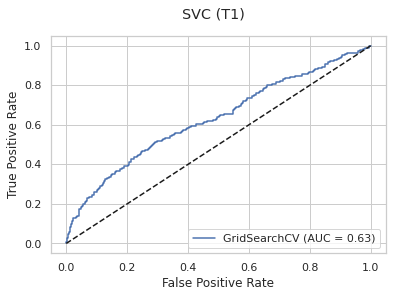

In [ ]:
svc_param = {
    'C': [1], 
     'gamma': ['scale'], 
    'kernel': ['linear','rbf']
}

#model_t1_svm = model_svc(**t1train,param=svc_param_default) 
model_t1_svm = model_svc(**t1train,param=svc_param)
print_acc_roc(model_t1_svm, **t1train, **t1test, supt = 'SVC (T1)')

In [17]:
for k,v in T1_ttsplit.items():
    print(k)

control_T1_5_250
control_T1_5_250_b2
control_T1_5_250_b4
control_T1_5_250_b6
control_T1_5_250_b8
control_T1_5_250_b10


Training control_T1_5_250
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.0s finished


,mean_test_score,std_test_score,params,mean_train_score
0,0.612794,0.039840,"{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}",0.612215
1,0.630868,0.028312,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.649858


train acc:  SVC (T1) 0.6489485981308412
test acc:  SVC (T1) 0.6231292517006802
mean cv score:  0.6308683530531756
best model:  {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
TN:  372
FP:  57
FN:  220
TP:  86
sensitivity:  0.28104575163398693
specificity:  0.8671328671328671
cannot plot top 20 features (rbf kernel)
Training control_T1_5_250_b2
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.8s finished


,mean_test_score,std_test_score,params,mean_train_score
0,0.612209,0.040202,"{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}",0.612085
1,0.630882,0.025727,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.646353


train acc:  SVC (T1) 0.6477803738317757
test acc:  SVC (T1) 0.6231292517006802
mean cv score:  0.6308819529443763
best model:  {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
TN:  382
FP:  47
FN:  230
TP:  76
sensitivity:  0.24836601307189543
specificity:  0.8904428904428905
cannot plot top 20 features (rbf kernel)
Training control_T1_5_250_b4
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.8s finished


,mean_test_score,std_test_score,params,mean_train_score
0,0.61104,0.039875,"{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}",0.610917
1,0.62737,0.027758,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.649923


train acc:  SVC (T1) 0.6489485981308412
test acc:  SVC (T1) 0.6122448979591837
mean cv score:  0.6273697810417517
best model:  {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
TN:  366
FP:  63
FN:  222
TP:  84
sensitivity:  0.27450980392156865
specificity:  0.8531468531468531
cannot plot top 20 features (rbf kernel)
Training control_T1_5_250_b6
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.8s finished


,mean_test_score,std_test_score,params,mean_train_score
0,0.611625,0.039441,"{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}",0.612410
1,0.633806,0.032096,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.653298


train acc:  SVC (T1) 0.6518691588785047
test acc:  SVC (T1) 0.6258503401360545
mean cv score:  0.6338059295525635
best model:  {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
TN:  373
FP:  56
FN:  219
TP:  87
sensitivity:  0.28431372549019607
specificity:  0.8694638694638694
cannot plot top 20 features (rbf kernel)
Training control_T1_5_250_b8
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.9s finished


,mean_test_score,std_test_score,params,mean_train_score
0,0.610455,0.039955,"{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}",0.610593
1,0.623280,0.026966,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.646288


train acc:  SVC (T1) 0.6448598130841121
test acc:  SVC (T1) 0.6204081632653061
mean cv score:  0.6232796137630899
best model:  {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
TN:  378
FP:  51
FN:  228
TP:  78
sensitivity:  0.2549019607843137
specificity:  0.8811188811188811
cannot plot top 20 features (rbf kernel)
Training control_T1_5_250_b10
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.8s finished


,mean_test_score,std_test_score,params,mean_train_score
0,0.611625,0.039872,"{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}",0.611436
1,0.632058,0.028766,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.653362


train acc:  SVC (T1) 0.6507009345794392
test acc:  SVC (T1) 0.6095238095238096
mean cv score:  0.6320583435332516
best model:  {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
TN:  373
FP:  56
FN:  231
TP:  75
sensitivity:  0.24509803921568626
specificity:  0.8694638694638694
cannot plot top 20 features (rbf kernel)
Training control_T1_5_250_b20
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.8s finished


,mean_test_score,std_test_score,params,mean_train_score
0,0.613379,0.039982,"{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}",0.613383
1,0.636149,0.026259,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.678350


train acc:  SVC (T1) 0.6787383177570093
test acc:  SVC (T1) 0.6122448979591837
mean cv score:  0.6361485108119135
best model:  {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
TN:  354
FP:  75
FN:  210
TP:  96
sensitivity:  0.3137254901960784
specificity:  0.8251748251748252
cannot plot top 20 features (rbf kernel)
Training control_T1_5_250_b30
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.8s finished


,mean_test_score,std_test_score,params,mean_train_score
0,0.609285,0.037352,"{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}",0.609619
1,0.608109,0.032263,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.672249


train acc:  SVC (T1) 0.6092289719626168
test acc:  SVC (T1) 0.5891156462585034
mean cv score:  0.6092853257173944
best model:  {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
TN:  322
FP:  107
FN:  195
TP:  111
sensitivity:  0.3627450980392157
specificity:  0.7505827505827506
Training control_T1_5_250_b40
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.9s finished


,mean_test_score,std_test_score,params,mean_train_score
0,0.609874,0.039384,"{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}",0.610203
1,0.630892,0.031327,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.702818


train acc:  SVC (T1) 0.6945093457943925
test acc:  SVC (T1) 0.6394557823129252
mean cv score:  0.6308921528627771
best model:  {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
TN:  356
FP:  73
FN:  192
TP:  114
sensitivity:  0.37254901960784315
specificity:  0.8298368298368298
cannot plot top 20 features (rbf kernel)


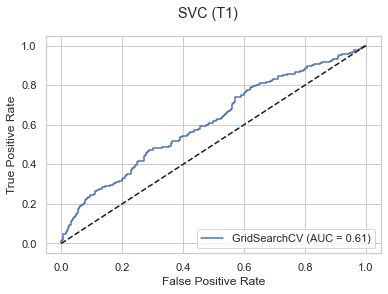

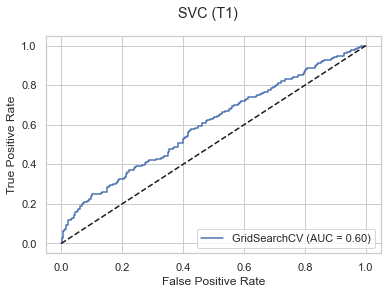

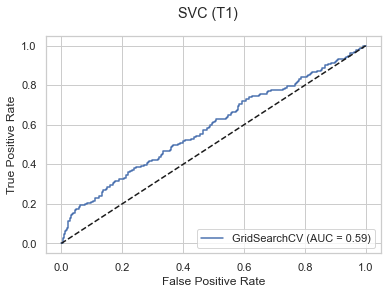

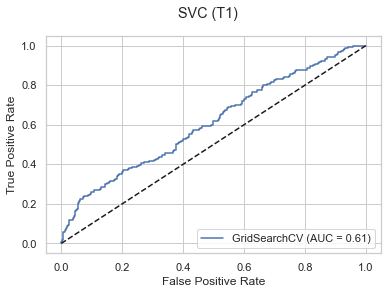

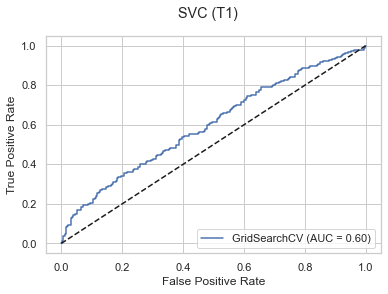

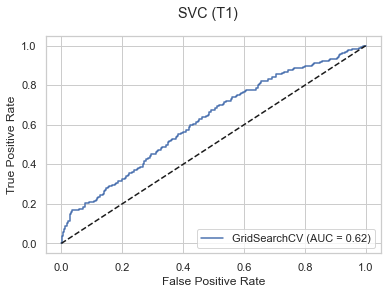

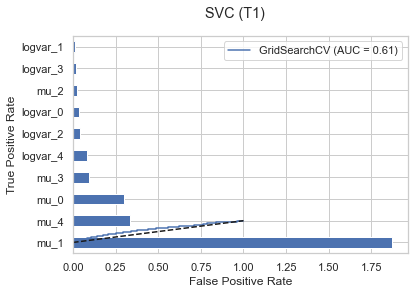

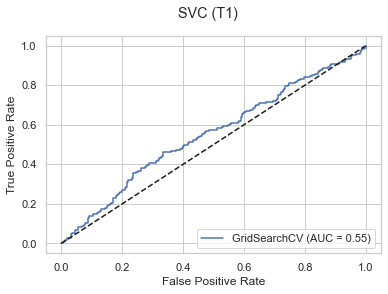

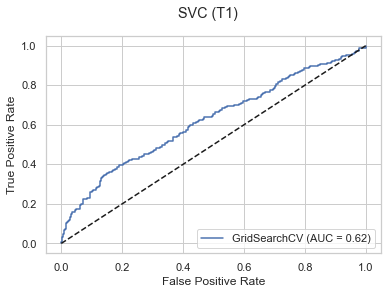

In [24]:
svc_param = {
    'C': [1], 
     'gamma': ['scale'], 
    'kernel': ['linear','rbf']
}

for k,v in T1_ttsplit.items():
  print("Training", k)
  t1train, t1test = v
  model_t1_svm = model_svc(**t1train,param=svc_param)
  print_acc_roc(model_t1_svm, **t1train, **t1test, supt = 'SVC (T1)')

Training 5_250
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 57.8min finished


,mean_test_score,std_test_score,params,mean_train_score
0,0.580165,0.002380,"{'max_depth': 2, 'max_features': 2, 'n_estimators': 10000}",0.582625
1,0.580165,0.002380,"{'max_depth': 2, 'max_features': 2, 'n_estimators': 12000}",0.582877
2,0.580165,0.002380,"{'max_depth': 2, 'max_features': 3, 'n_estimators': 10000}",0.583066
3,0.580165,0.002380,"{'max_depth': 2, 'max_features': 3, 'n_estimators': 12000}",0.583128
4,0.539359,0.029671,"{'max_depth': None, 'max_features': 2, 'n_estimators': 10000}",1.000000
5,0.544463,0.030050,"{'max_depth': None, 'max_features': 2, 'n_estimators': 12000}",1.000000
6,0.539365,0.029596,"{'max_depth': None, 'max_features': 3, 'n_estimators': 10000}",1.000000
7,0.538232,0.030146,"{'max_depth': None, 'max_features': 3, 'n_estimators': 12000}",1.000000


train acc:  Random Forest (T1) 0.5807365439093485
test acc:  Random Forest (T1) 0.5904887714663144
mean cv score:  0.5801649974319467
best model:  {'max_depth': 2, 'max_features': 2, 'n_estimators': 10000}
TN:  447
FP:  0
FN:  310
TP:  0
sensitivity:  0.0
specificity:  1.0


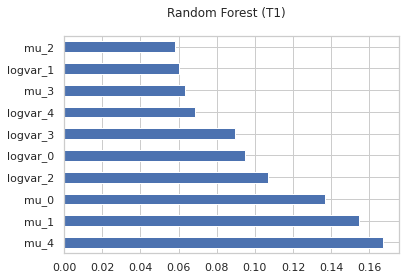

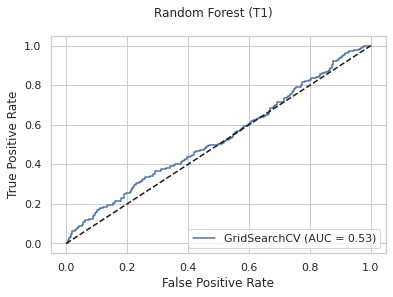

In [ ]:
rf_param = {
    'n_estimators': [10000, 12000],
    'max_features': [2,3],
    'max_depth':[ 2, None],
}

for k,v in T1_ttsplit.items():
  print("Training", k)
  t1train, t1test = v
  model_t1_rfc2 = model_rf(**t1train, param=rf_param)
  print_acc_roc(model_t1_rfc2, **t1train, **t1test, supt='Random Forest (T1)')

In [ ]:
rf_param = {
    'n_estimators': [10000, 12000],
    'max_features': [2,3],
    'max_depth':[ 2, None],
}

model_t1_rfc2 = model_rf(**t1train, param=rf_param)
print_acc_roc(model_t1_rfc2, **t1train, **t1test, supt='Random Forest (T1)')

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 124.9min finished


,mean_test_score,std_test_score,params,mean_train_score
0,0.568837,0.005932,"{'max_depth': 3, 'max_features': 2, 'n_estimators': 20000}",0.584891
1,0.569405,0.006112,"{'max_depth': 3, 'max_features': 2, 'n_estimators': 30000}",0.585080
2,0.568272,0.006992,"{'max_depth': 3, 'max_features': 3, 'n_estimators': 20000}",0.590934
3,0.568272,0.006992,"{'max_depth': 3, 'max_features': 3, 'n_estimators': 30000}",0.590809
4,0.569408,0.008557,"{'max_depth': 3, 'max_features': 4, 'n_estimators': 20000}",0.595215
5,0.569411,0.009480,"{'max_depth': 3, 'max_features': 4, 'n_estimators': 30000}",0.595215
6,0.571103,0.008442,"{'max_depth': 4, 'max_features': 2, 'n_estimators': 20000}",0.607239
7,0.571668,0.008579,"{'max_depth': 4, 'max_features': 2, 'n_estimators': 30000}",0.608183
8,0.569967,0.011027,"{'max_depth': 4, 'max_features': 3, 'n_estimators': 20000}",0.621277
9,0.569967,0.011601,"{'max_depth': 4, 'max_features': 3, 'n_estimators': 30000}",0.621277


train acc:  Random Forest (T1) 0.6005665722379604
test acc:  Random Forest (T1) 0.6235138705416117
mean cv score:  0.5716679506933744
best model:  {'max_depth': 4, 'max_features': 2, 'n_estimators': 30000}
TN:  467
FP:  3
FN:  282
TP:  5
sensitivity:  0.017421602787456445
specificity:  0.9936170212765958


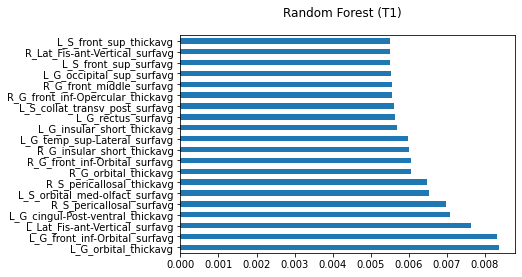

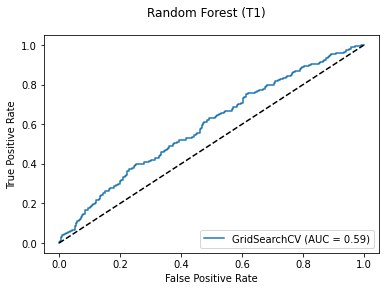

In [ ]:
rf_param3 = {
    'n_estimators': [20000,30000],
    'max_features': [2, 3, 4],
    'max_depth':[3, 4],
}

model_t1_rfc4 = model_rf(**t1train, param=rf_param3)
print_acc_roc(model_t1_rfc4, **t1train, **t1test, supt='Random Forest (T1)')

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    3.4s finished


,mean_test_score,std_test_score,params,mean_train_score
0,0.585266,0.002553,"{'C': 0.1, 'kernel': 'linear'}",0.589738
1,0.586399,0.001172,"{'C': 0.01, 'kernel': 'linear'}",0.586402
2,0.586399,0.001172,"{'C': 0.001, 'kernel': 'linear'}",0.586402


train acc:  SVC (T1) 0.5864022662889519
test acc:  SVC (T1) 0.5772787318361955
mean cv score:  0.5863989470980997
best model:  {'C': 0.01, 'kernel': 'linear'}
TN:  437
FP:  0
FN:  320
TP:  0
sensitivity:  0.0
specificity:  1.0


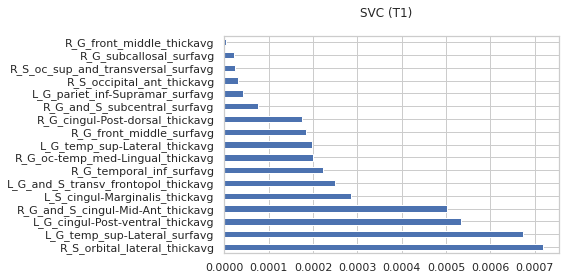

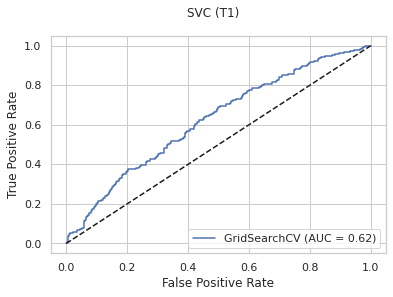

In [ ]:
svc_param2 = {
    'C': [ .1, .01, .001], 
#    'gamma': ['auto','scale'], 
    'kernel': ['linear']
}
# model_t_svm4 = model_svc(**t1train, param=svc_param2)
# print_acc_roc(model_t_svm4, **t1train, **t1test, supt = 'SVC (T1)')

model_t_svm4 = model_svc(X_train_RFE,y_train, param=svc_param2)
print_acc_roc(model_t_svm4, X_train_RFE,X_test_RFE,y_train,y_test, supt = 'SVC (T1)')

## merged

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 111.1min finished


,mean_test_score,std_test_score,params,mean_train_score
0,0.572451,0.026093,"{'max_depth': 3, 'max_features': 2, 'n_estimators': 20000}",0.680458
1,0.572432,0.026433,"{'max_depth': 3, 'max_features': 2, 'n_estimators': 30000}",0.681683
2,0.576541,0.027547,"{'max_depth': 3, 'max_features': 3, 'n_estimators': 20000}",0.694865
3,0.579319,0.029518,"{'max_depth': 3, 'max_features': 3, 'n_estimators': 30000}",0.696397
4,0.577892,0.030087,"{'max_depth': 3, 'max_features': 4, 'n_estimators': 20000}",0.706053
5,0.577892,0.028116,"{'max_depth': 3, 'max_features': 4, 'n_estimators': 30000}",0.705286
6,0.582078,0.030532,"{'max_depth': 4, 'max_features': 2, 'n_estimators': 20000}",0.758158
7,0.579319,0.031877,"{'max_depth': 4, 'max_features': 2, 'n_estimators': 30000}",0.757699
8,0.579300,0.029752,"{'max_depth': 4, 'max_features': 3, 'n_estimators': 20000}",0.775784
9,0.580689,0.032086,"{'max_depth': 4, 'max_features': 3, 'n_estimators': 30000}",0.774558


train acc:  Random Forest (T1&DTI) 0.7779310344827586
test acc:  Random Forest (T1&DTI) 0.5705128205128205
mean cv score:  0.5848173515981735
best model:  {'max_depth': 4, 'max_features': 4, 'n_estimators': 30000}
TN:  153
FP:  22
FN:  112
TP:  25
sensitivity:  0.18248175182481752
specificity:  0.8742857142857143


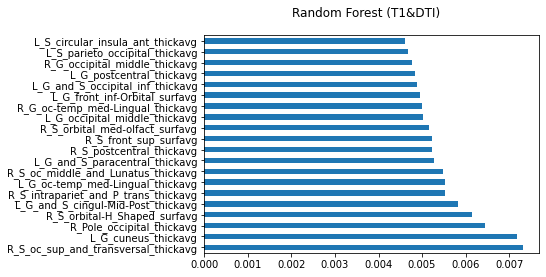

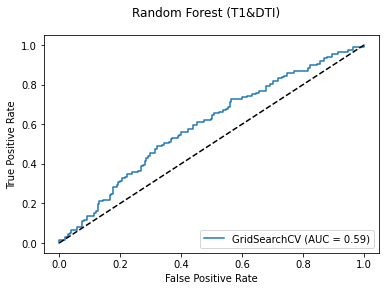

In [ ]:
rf_param3 = {
    'n_estimators': [20000, 30000],
    'max_features': [2, 3, 4],
    'max_depth':[3, 2]
}

model_m = model_rf(**mtrain, param=rf_param3)
print_acc_roc(model_m, **mtrain, **mtest, supt='Random Forest (T1&DTI)')

In [ ]:
model_t_svm4 = model_svc(**t1train, param=svc_param2)
print_acc_roc(model_t_svm4, **t1train, **t1test, supt = 'SVC (T1)')

## DTI

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   26.7s finished


,mean_test_score,std_test_score,params,mean_train_score
0,0.538386,0.027727,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'}",0.587580
1,0.554498,0.001936,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}",0.554499
2,0.538386,0.027727,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}",0.587580
3,0.554498,0.001936,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}",0.554499
4,0.549351,0.031383,"{'C': 0.01, 'gamma': 'auto', 'kernel': 'linear'}",0.576688
5,0.554498,0.001936,"{'C': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}",0.554499
6,0.549351,0.031383,"{'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}",0.576688
7,0.554498,0.001936,"{'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}",0.554499
8,0.554498,0.001936,"{'C': 0.001, 'gamma': 'auto', 'kernel': 'linear'}",0.554499
9,0.554498,0.001936,"{'C': 0.001, 'gamma': 'auto', 'kernel': 'rbf'}",0.554499


train acc:  SVC (DTI) 0.5544989027066569
test acc:  SVC (DTI) 0.5631399317406144
mean cv score:  0.5544976384714471
best model:  {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
TN:  0
FP:  256
FN:  0
TP:  330
sensitivity:  1.0
specificity:  0.0
cannot plot top 20 features (rbf kernel)


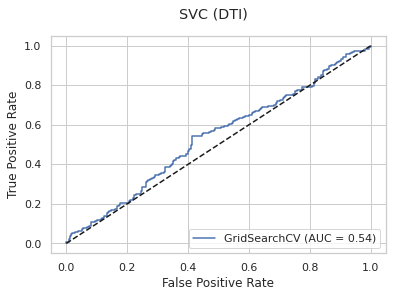

In [ ]:
svc_param = {
    'C': [ .1, .01, .001,0.5,1], 
     'gamma': ['auto','scale'], 
    'kernel': ['linear','rbf']
}

model_dti_svm = model_svc(**dtitrain, param=svc_param)
print_acc_roc(model_dti_svm, **dtitrain, **dtitest, supt = 'SVC (DTI)')

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  3.8min finished


train acc:  Random Forest (DTI) 0.562545720555962
test acc:  Random Forest (DTI) 0.5443686006825939
mean cv score:  0.5603477887505368
best model:  {'criterion': 'gini', 'max_depth': 2, 'max_features': 2, 'n_estimators': 1000}
TN:  0
FP:  267
FN:  0
TP:  319
sensitivity:  1.0
specificity:  0.0


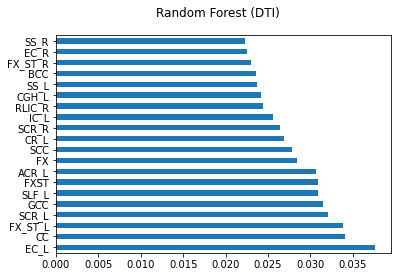

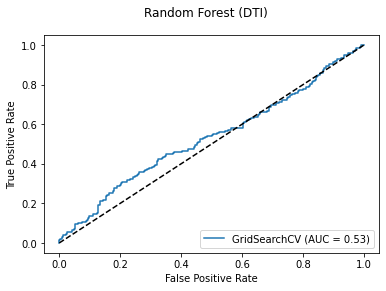

In [ ]:
rf_param = {
    'n_estimators': [1000, 1500],
    'max_features': [2,3],
    'max_depth':[ 2, None],
    'criterion': ['gini']
}
model_dti_rfc = model_rf(**dtitrain, param=rf_param)
print_acc_roc(model_dti_rfc, **dtitrain, **dtitest, supt = 'Random Forest (DTI)')

In [ ]:
rf_param2 = {
    'n_estimators': [600, 800],
    'max_features': [ 3, 6, 8],
    'max_depth':[ None, 3, 5 ],
#     'n_jobs':[-1]
}
model_dti_rfc2 = model_rf(**dtitrain, param=rf_param2)
print_acc_roc(model_dti_rfc2, **dtitrain, **dtitest, supt = 'Random Forest (DTI)')

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 16.7min finished


train acc:  Random Forest (DTI) 0.5786393562545721
test acc:  Random Forest (DTI) 0.5648464163822525
mean cv score:  0.564759553456419
best model:  {'max_depth': 2, 'max_features': 5, 'n_estimators': 8000}
TN:  10
FP:  247
FN:  8
TP:  321
sensitivity:  0.9756838905775076
specificity:  0.038910505836575876


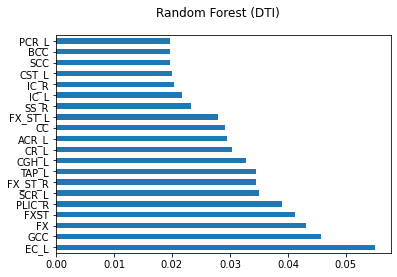

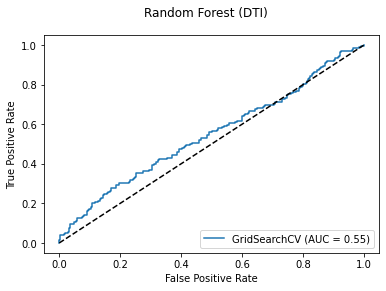

In [ ]:
rf_param3 = {
    'n_estimators': [6000, 8000],
    'max_features': [3, 5],
    'max_depth':[ 2, 3]
}

model_dti_rfc3 = model_rf(**dtitrain, param=rf_param3)
print_acc_roc(model_dti_rfc3, **dtitrain, **dtitest, supt = 'Random Forest (DTI)')

## merged

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   36.1s finished


,mean_test_score,std_test_score,params,mean_train_score
0,0.555974,0.026145,"{'C': 1, 'kernel': 'linear'}",0.940537
1,0.529623,0.034420,"{'C': 10, 'kernel': 'linear'}",0.990345
2,0.565601,0.034354,"{'C': 0.1, 'kernel': 'linear'}",0.874327


train acc:  SVC (T1 & DTI) 0.8537931034482759
test acc:  SVC (T1 & DTI) 0.5352564102564102
mean cv score:  0.5656012176560121
best model:  {'C': 0.1, 'kernel': 'linear'}
TN:  97
FP:  78
FN:  67
TP:  70
sensitivity:  0.5109489051094891
specificity:  0.5542857142857143


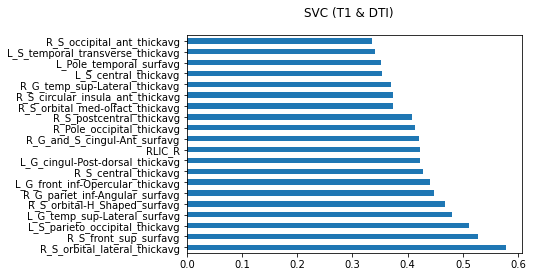

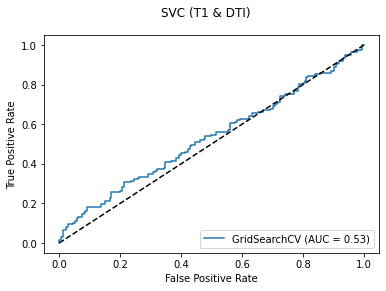

In [ ]:
svc_param2 = {
    'C': [ 1, .1, .01 ],  
#     'gamma': ['auto','scale'], 
    'kernel': ['linear']
}

model_m_svm2 = model_svc(**mtrain, param=svc_param2)
print_acc_roc(model_m_svm2, **mtrain, **mtest, supt = 'SVC (T1 & DTI)')

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    9.6s finished


,mean_test_score,std_test_score,params,mean_train_score
0,0.539326,0.004526,"{'C': 0.0001, 'kernel': 'linear'}",0.539311
1,0.584893,0.028099,"{'C': 0.01, 'kernel': 'linear'}",0.788970
2,0.572374,0.033015,"{'C': 0.001, 'kernel': 'linear'}",0.632490


train acc:  SVC (T1 & DTI) 0.7710344827586207
test acc:  SVC (T1 & DTI) 0.5608974358974359
mean cv score:  0.5848934550989344
best model:  {'C': 0.01, 'kernel': 'linear'}
TN:  117
FP:  58
FN:  79
TP:  58
sensitivity:  0.4233576642335766
specificity:  0.6685714285714286


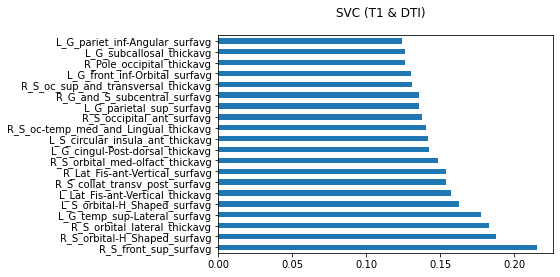

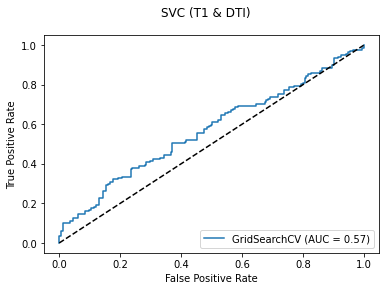

In [ ]:
svc_param2 = {
    'C': [ .0001, .01, .001 ],  
#     'gamma': ['auto','scale'], 
    'kernel': ['linear']
}

model_m_svm4 = model_svc(**mtrain, param=svc_param2)
print_acc_roc(model_m_svm4, **mtrain, **mtest, supt = 'SVC (T1 & DTI)')

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 160.8min finished


train acc:  Random Forest (T1 & DTI) 1.0
test acc:  Random Forest (T1 & DTI) 0.6025641025641025
mean cv score:  0.5904299847793
best model:  {'max_depth': None, 'max_features': 3, 'n_estimators': 50000}
TN:  133
FP:  52
FN:  72
TP:  55
sensitivity:  0.4330708661417323
specificity:  0.7189189189189189


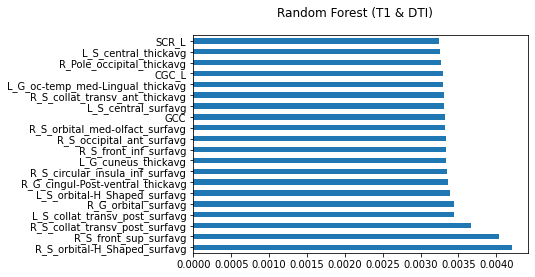

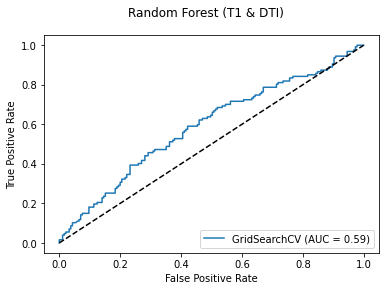

In [ ]:
rf_param2 = {
    'n_estimators': [50000, 70000],
    'max_features': [2,3],
    'max_depth':[ 2, None]
}
model_m_rfc2 = model_rf(**mtrain, param=rf_param2)
print_acc_roc(model_m_rfc2, **mtrain, **mtest, supt = 'Random Forest (T1 & DTI)')

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 294.7min finished


train acc:  Random Forest (T1 & DTI) 0.886896551724138
test acc:  Random Forest (T1 & DTI) 0.592948717948718
mean cv score:  0.5698059360730594
best model:  {'max_depth': 5, 'max_features': 3, 'n_estimators': 90000}
TN:  146
FP:  39
FN:  88
TP:  39
sensitivity:  0.30708661417322836
specificity:  0.7891891891891892


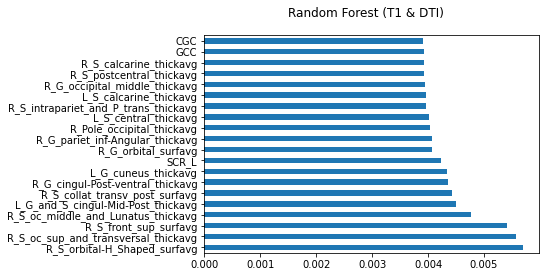

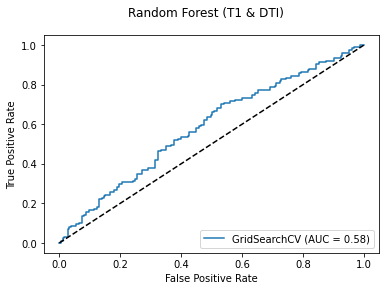

In [ ]:
rf_param3 = {
    'n_estimators': [90000, 120000],
    'max_features': [2,3],
    'max_depth':[ 3,5 ],
#     'criterion': ['gini'],
#     'n_jobs':[-1]
}
model_m_rfc3 = model_rf(**mtrain, param=rf_param3)
print_acc_roc(model_m_rfc3, **mtrain, **mtest, supt = 'Random Forest (T1 & DTI)')

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 94.4min finished


,mean_test_score,std_test_score,params,mean_train_score
0,0.561549,0.039213,"{'criterion': 'gini', 'max_depth': 3, 'max_features': 2, 'n_estimators': 30000, 'n_jobs': -1}",0.705742
1,0.565677,0.038565,"{'criterion': 'gini', 'max_depth': 3, 'max_features': 2, 'n_estimators': 50000, 'n_jobs': -1}",0.706507
2,0.564288,0.036661,"{'criterion': 'gini', 'max_depth': 3, 'max_features': 3, 'n_estimators': 30000, 'n_jobs': -1}",0.716163
3,0.564269,0.036344,"{'criterion': 'gini', 'max_depth': 3, 'max_features': 3, 'n_estimators': 50000, 'n_jobs': -1}",0.715398
4,0.554623,0.046167,"{'criterion': 'gini', 'max_depth': 4, 'max_features': 2, 'n_estimators': 30000, 'n_jobs': -1}",0.797083
5,0.558790,0.049463,"{'criterion': 'gini', 'max_depth': 4, 'max_features': 2, 'n_estimators': 50000, 'n_jobs': -1}",0.798156
6,0.565677,0.056051,"{'criterion': 'gini', 'max_depth': 4, 'max_features': 3, 'n_estimators': 30000, 'n_jobs': -1}",0.815015
7,0.560103,0.049026,"{'criterion': 'gini', 'max_depth': 4, 'max_features': 3, 'n_estimators': 50000, 'n_jobs': -1}",0.815781
8,0.557420,0.057664,"{'criterion': 'gini', 'max_depth': 5, 'max_features': 2, 'n_estimators': 30000, 'n_jobs': -1}",0.884750
9,0.562919,0.060228,"{'criterion': 'gini', 'max_depth': 5, 'max_features': 2, 'n_estimators': 50000, 'n_jobs': -1}",0.883678


train acc:  Random Forest (T1 & DTI) 0.8855172413793103
test acc:  Random Forest (T1 & DTI) 0.5993589743589743
mean cv score:  0.5698059360730594
best model:  {'criterion': 'gini', 'max_depth': 5, 'max_features': 3, 'n_estimators': 50000, 'n_jobs': -1}
TN:  148
FP:  37
FN:  88
TP:  39
sensitivity:  0.30708661417322836
specificity:  0.8


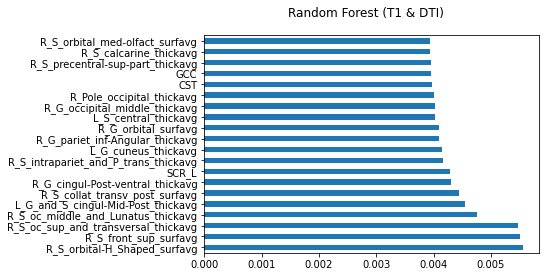

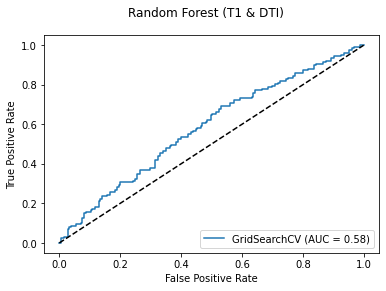

In [ ]:
rf_param3 = {
    'n_estimators': [30000, 50000],
    'max_features': [2, 3],
    'max_depth':[ 3, 4, 5 ],
    'criterion': ['gini'],
    'n_jobs':[-1]
}
model_m_rfc3 = model_rf(**mtrain, param=rf_param3)
print_acc_roc(model_m_rfc3, **mtrain, **mtest, supt = 'Random Forest (T1 & DTI)')

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 17.6min finished


,mean_test_score,std_test_score,params,mean_train_score
0,0.577930,0.058815,"{'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'n_estimators': 600, 'n_jobs': -1}",0.815170
1,0.577930,0.054201,"{'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'n_estimators': 800, 'n_jobs': -1}",0.815787
2,0.571043,0.033161,"{'criterion': 'gini', 'max_depth': 3, 'max_features': 3, 'n_estimators': 600, 'n_jobs': -1}",0.678317
3,0.573820,0.029218,"{'criterion': 'gini', 'max_depth': 3, 'max_features': 3, 'n_estimators': 800, 'n_jobs': -1}",0.680002
4,0.572489,0.028293,"{'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'n_estimators': 600, 'n_jobs': -1}",0.699312
5,0.566914,0.031777,"{'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'n_estimators': 800, 'n_jobs': -1}",0.697625
6,0.591724,0.061203,"{'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'n_estimators': 600, 'n_jobs': -1}",0.967509
7,0.583505,0.058042,"{'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'n_estimators': 800, 'n_jobs': -1}",0.967509
8,0.580651,0.048425,"{'criterion': 'gini', 'max_depth': 5, 'max_features': 3, 'n_estimators': 600, 'n_jobs': -1}",0.840915
9,0.579281,0.044989,"{'criterion': 'gini', 'max_depth': 5, 'max_features': 3, 'n_estimators': 800, 'n_jobs': -1}",0.837852


train acc:  Random Forest (T1&DTI) 0.9696551724137931
test acc:  Random Forest (T1&DTI) 0.5801282051282052
mean cv score:  0.5931126331811264
best model:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 5, 'n_estimators': 600, 'n_jobs': -1}
TN:  138
FP:  27
FN:  104
TP:  43
sensitivity:  0.2925170068027211
specificity:  0.8363636363636363


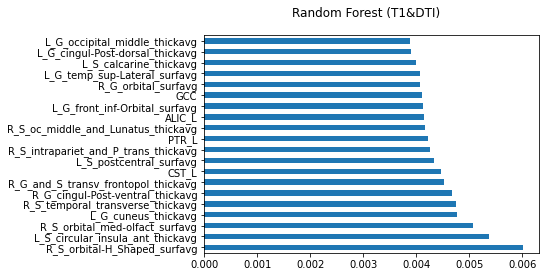

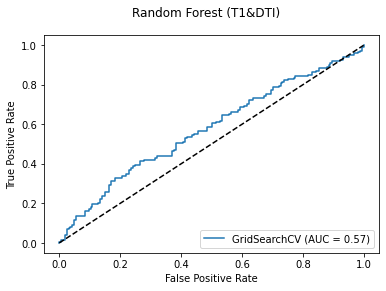

In [ ]:
model_mm_rfc3 = model_rf(**mtrain, param=rf_param3)
print_acc_roc(model_mm_rfc3, **mtrain, **mtest, supt = 'Random Forest (T1&DTI)')

**RS**

In [ ]:
svc_param = {
    'C': [ .1, .01, 1], 
     'gamma': ['auto','scale'], 
    'kernel': ['linear','rbf']
}

print(rstrain)

model_rs_svm = model_svc(**rstrain, param=svc_param)

print_acc_roc(model_rs_svm, **rstrain, **rstest, supt = 'SVC (DTI)')

{'trainx':           mu_0      mu_1      mu_2  ...  logvar_7  logvar_8  logvar_9
0    -0.416018 -0.323430  0.821733  ...  0.000000  0.000000  0.000000
1    -0.416246  0.437031 -0.258670  ...  0.000000  0.000000  0.000000
2    -0.013712 -0.393872 -0.345577  ... -0.596481 -0.544422 -0.585778
3     0.685041  0.006547 -0.345787  ...  1.927078  6.719617  2.228402
4     1.126268  0.808978  1.549845  ...  0.480834  0.393786  0.549855
...        ...       ...       ...  ...       ...       ...       ...
1724 -0.334063  0.467490 -0.340844  ...  1.313594  0.453136  1.501576
1725  0.000000  0.501608  0.698976  ... -0.345312 -0.474603 -0.405350
1726 -0.382881  0.541172 -0.333698  ...  1.474766  2.279236  2.227777
1727  0.254661  0.334508 -0.226563  ...  6.842983  3.121208  5.877514
1728  0.376714 -0.393604 -0.344726  ... -0.602020 -0.586336 -0.583847

[1729 rows x 20 columns], 'trainy': 494     0
365     0
2232    1
1511    1
273     0
       ..
1638    0
1095    0
1130    0
1294    0
860     0
Na

ValueError: ignored